## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt


import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')

In [3]:
import data.read
importlib.reload(data.read)

<module 'data.read' from '/home/junlim/projects/jitter_recovery/data/read.py'>

In [23]:
df = data.read.df_binance_20240125_0130
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])
all_symbols = df.symbol.unique()

In [24]:
df.tail(3)

,timestamp,symbol,open,high,low,close,volume
2685224,2024-01-30 04:58:00,WRXUSDT,0.2174,0.2176,0.2174,0.2176,446.50
2685225,2024-01-30 04:58:00,ICPUSDT,12.3770,12.3850,12.3720,12.3850,1392.41
2685226,2024-01-30 04:58:00,LSKUSDT,1.4270,1.4270,1.4270,1.4270,817.10


In [25]:
len([s for s in all_symbols if 'USDT' in s])

373

## multiple symbols

In [26]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)

<module 'algo.jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research.py'>

In [27]:
jitter_recovery_feature_param = algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(40)
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    jitter_recovery_feature_param, 
    0.20, -0.04, 0.02, is_long_term=False)

In [28]:
dfst_feature = algo.jitter_recovery.research.get_dfst_feature(df, jitter_recovery_trading_param)

0 symbol: QKCUSDT: 0
1 symbol: BEAMXUSDT: 0
2 symbol: VANRYUSDT: 0
3 symbol: NULSUSDT: 0
4 symbol: ZECUSDT: 0
5 symbol: XTZUSDT: 0
6 symbol: GLMUSDT: 0
7 symbol: HFTUSDT: 0
8 symbol: MOBUSDT: 0
9 symbol: PERPUSDT: 0
10 symbol: PEOPLEUSDT: 0
11 symbol: BALUSDT: 0
12 symbol: ZILUSDT: 0
13 symbol: DEXEUSDT: 0
14 symbol: KMDUSDT: 0
15 symbol: NFPUSDT: 0
16 symbol: BARUSDT: 0
17 symbol: JSTUSDT: 0
18 symbol: CFXUSDT: 0
19 symbol: TWTUSDT: 0
20 symbol: BURGERUSDT: 0
21 symbol: APEUSDT: 0
22 symbol: OMGUSDT: 0
23 symbol: LAZIOUSDT: 0
24 symbol: TIAUSDT: 0
25 symbol: FLUXUSDT: 0
26 symbol: AMPUSDT: 0
27 symbol: OSMOUSDT: 0
28 symbol: BNXUSDT: 0
29 symbol: XAIUSDT: 0
30 symbol: FILUSDT: 0
31 symbol: OPUSDT: 0
32 symbol: ORDIUSDT: 0
33 symbol: ANKRUSDT: 0
34 symbol: NMRUSDT: 0
35 symbol: ASTRUSDT: 0
36 symbol: LUNAUSDT: 0
37 symbol: CREAMUSDT: 0
38 symbol: ACMUSDT: 0
39 symbol: SEIUSDT: 0
40 symbol: AEURUSDT: 0
41 symbol: UNIUSDT: 0
42 symbol: IRISUSDT: 0
43 symbol: TFUELUSDT: 0
44 symbol: COTIU

In [29]:
symbol_with_jumps = [s for s in list(set(list(dfst_feature[dfst_feature.ch_max >= 0.18].index.get_level_values(0)))) if 'USDT' in s]
len(symbol_with_jumps)

7

In [30]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)

<module 'algo.jitter_recovery.calculate' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/calculate.py'>

In [31]:
dfst_trading = algo.jitter_recovery.research.get_dfst_trading(df, symbol_with_jumps, jitter_recovery_trading_param)

0 symbol: PROMUSDT
1 symbol: DCRUSDT
2 symbol: ARKUSDT
3 symbol: RAREUSDT
4 symbol: OMUSDT
5 symbol: MULTIUSDT
6 symbol: POLSUSDT


<Axes: xlabel='timestamp'>

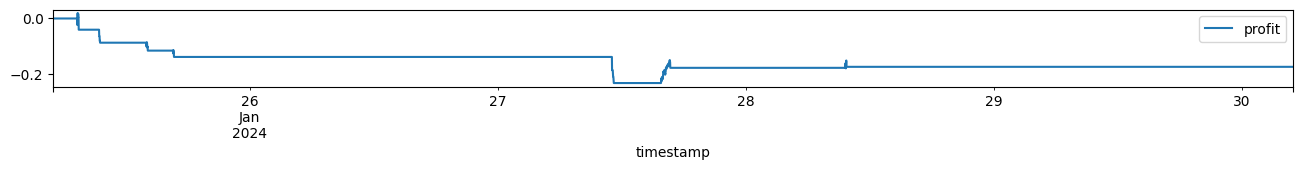

In [32]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

In [33]:
dfst_trading[dfst_trading.profit != 0].dropna()[['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
DCRUSDT,-0.093880
PROMUSDT,-0.075276
ARKUSDT,-0.040330
OMUSDT,-0.022720
MULTIUSDT,0.003604
POLSUSDT,0.054716


In [34]:
#dfst_feature.xs('FITFI-USDT-SWAP').loc['2023-12-07 16:38:00']

In [38]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-25 07:18:00, ARKUSDT, 1.1201, position_changed: 1.0
2024-01-25 07:19:00, ARKUSDT, 1.1456, position_changed: -1.0
2024-01-25 07:20:00, ARKUSDT, 1.1786, position_changed: 1.0
2024-01-25 07:28:00, ARKUSDT, 1.1971, position_changed: -1.0
2024-01-25 09:26:00, PROMUSDT, 8.0, position_changed: 1.0
2024-01-25 09:27:00, PROMUSDT, 8.189, position_changed: -1.0
2024-01-25 09:29:00, PROMUSDT, 7.919, position_changed: 1.0
2024-01-25 09:32:00, PROMUSDT, 8.103, position_changed: -1.0
2024-01-25 14:00:00, PROMUSDT, 8.601, position_changed: 1.0
2024-01-25 14:09:00, PROMUSDT, 8.847, position_changed: -1.0
2024-01-25 16:35:00, OMUSDT, 0.10078, position_changed: 1.0
2024-01-25 16:41:00, OMUSDT, 0.10307, position_changed: -1.0
2024-01-27 11:03:00, DCRUSDT, 19.67, position_changed: 1.0
2024-01-27 11:04:00, DCRUSDT, 20.61, position_changed: -1.0
2024-01-27 11:08:00, DCRUSDT, 20.18, position_changed: 1.0
2024-01-27 11:10:00, DCRUSDT, 20.64, position_changed: -1.0
2024-01-27 11:11:00, DCRUSDT, 20.35, p

## single symobl

In [43]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)

<module 'algo.jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research.py'>

In [49]:
symbol_investigate = 'DCRUSDT'
dfs = dfi.xs(symbol_investigate, level=1)

In [50]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(40), 
    0.20, -0.04, 0.02, is_long_term=False)

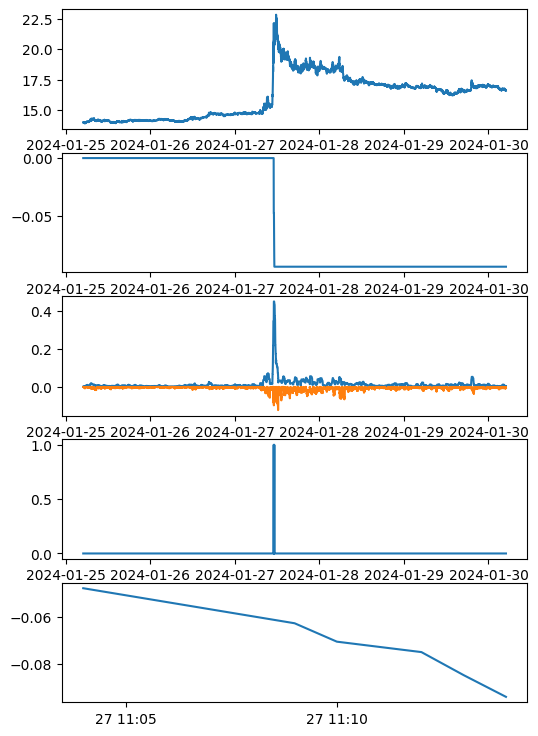

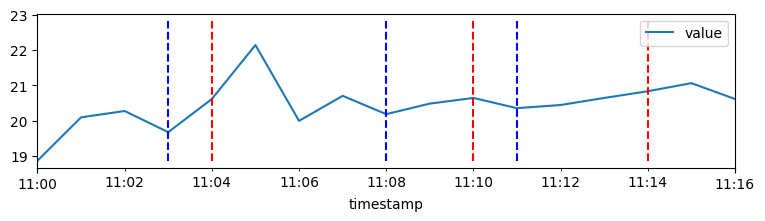

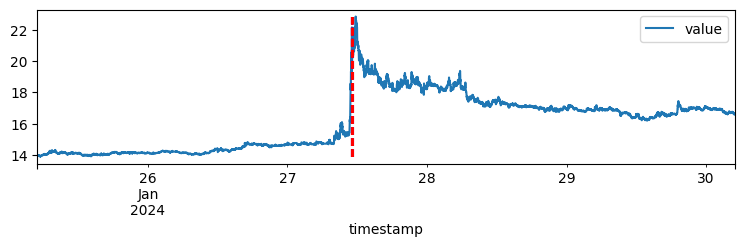

In [51]:
df_feature, df_trading = algo.jitter_recovery.research.investigate_symbol(df, symbol_investigate, jitter_recovery_trading_param)

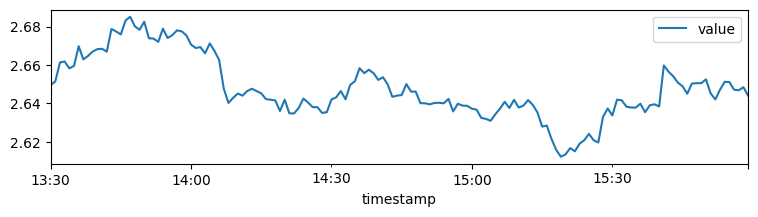

In [43]:
i_head = df_trading.index.get_loc(df_trading[df_trading.position_changed == +1].index[0])
i_tail = df_trading.index.get_loc(df_trading[df_trading.position_changed == -1].index[-1])
df_plot = df_trading.iloc[i_head-3:i_tail+3]
ax = df_plot[['value']].plot(figsize=(9,2))
ymin, ymax = df_plot[['value']].min(), df_trading[['value']].max()

ax.vlines(x=list(df_plot[df_plot.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(df_plot[df_plot.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='dashed', label='enter')

plt.show()

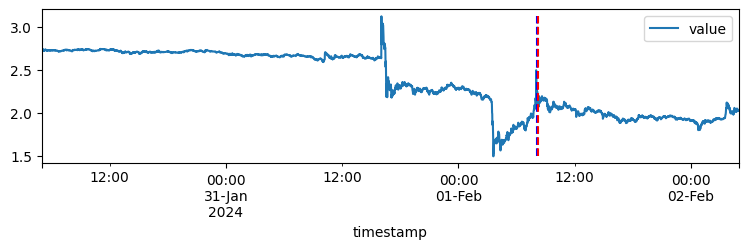

In [44]:
ax = df_trading[['value']].plot(figsize=(9,2))
ymin, ymax = df_trading[['value']].min(), df_trading[['value']].max()

ax.vlines(x=list(df_trading[df_trading.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(df_trading[df_trading.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='dashed', label='enter')

plt.show()

In [45]:
df_trading[
    (df_trading.index >=  '2024-01-03 12:14:00') &
    (df_trading.index <=  '2024-01-03 12:18:00')
]

,value,ch_max,ch_min,v_ch_max_is_from,v_ch_min_is_from,v_ch_max_is_to,v_ch_min_is_to,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,in_position,value_at_enter,position_changed,lowest_since_enter,timedelta_since_position_enter,ch_from_enter,ch_from_lowest_since_enter,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,,,,


In [47]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-01-27 15:48:00,0.8891,1,1.0,0.0000,0.000000
2024-01-27 16:42:00,0.8410,0,-1.0,-0.0164,-0.019888


In [48]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-27 15:48:00, POLSUSDT, 0.8891, position_changed: 1.0
2024-01-27 16:42:00, POLSUSDT, 0.841, position_changed: -1.0
